In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install --upgrade tensorflow
!pip install keras==2.15.0
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)


In [ ]:
from keras.layers import Input, Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
import time
import cv2
import glob
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from keras.models import load_model
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [ ]:
# Specify the path to your data in Google Drive
base_path = '/content/drive/MyDrive/chest_xray new data'




#**2) Loading Data**

In [ ]:
# Update the paths accordingly
train_data = glob.glob(os.path.join(base_path, 'train/**/*.jpeg'))
test_data = glob.glob(os.path.join(base_path, 'test/**/*.jpeg'))
val_data = glob.glob(os.path.join(base_path, 'val/**/*.jpeg'))

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 1644 images
Testing Set has: 624 images
Validation Set has: 16 images


In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    # Set up the figure and axes for subplots
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=(len(img_matrix_list) // ncols) + 1, ncols=ncols, squeeze=False)

    # Adjust layout
    fig.suptitle(main_title, fontsize=30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)

    # Enumerate through the images and titles
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        myaxes[row, col].imshow(img)
        myaxes[row, col].set_title(title, fontsize=15)

    # Remove empty subplots if any
    for i in range(len(img_matrix_list), len(myaxes.flatten())):
        fig.delaxes(myaxes.flatten()[i])

    plt.show()

#**3) Data Distribution**

In [ ]:
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(base_path, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 1496
Total Normal Images: 788


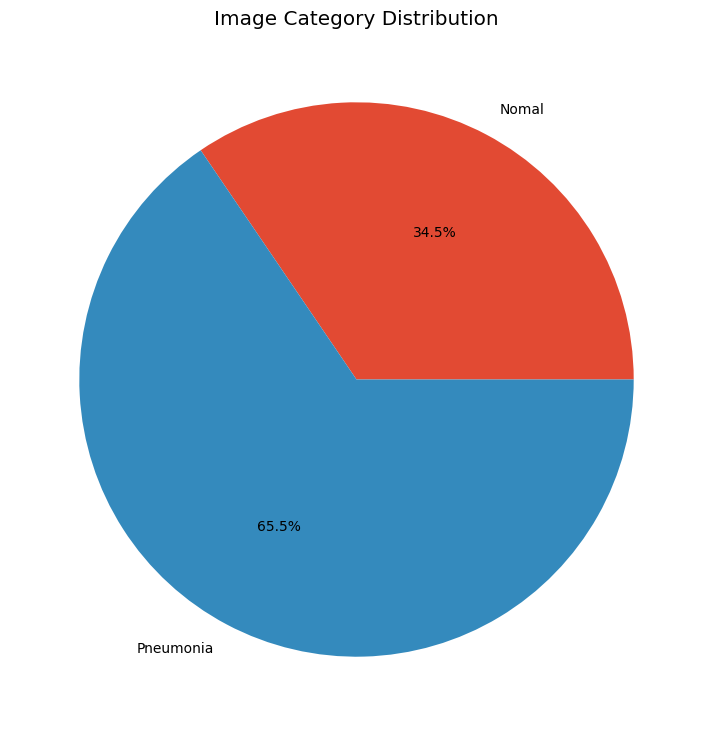

In [ ]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

#**4) EDA**

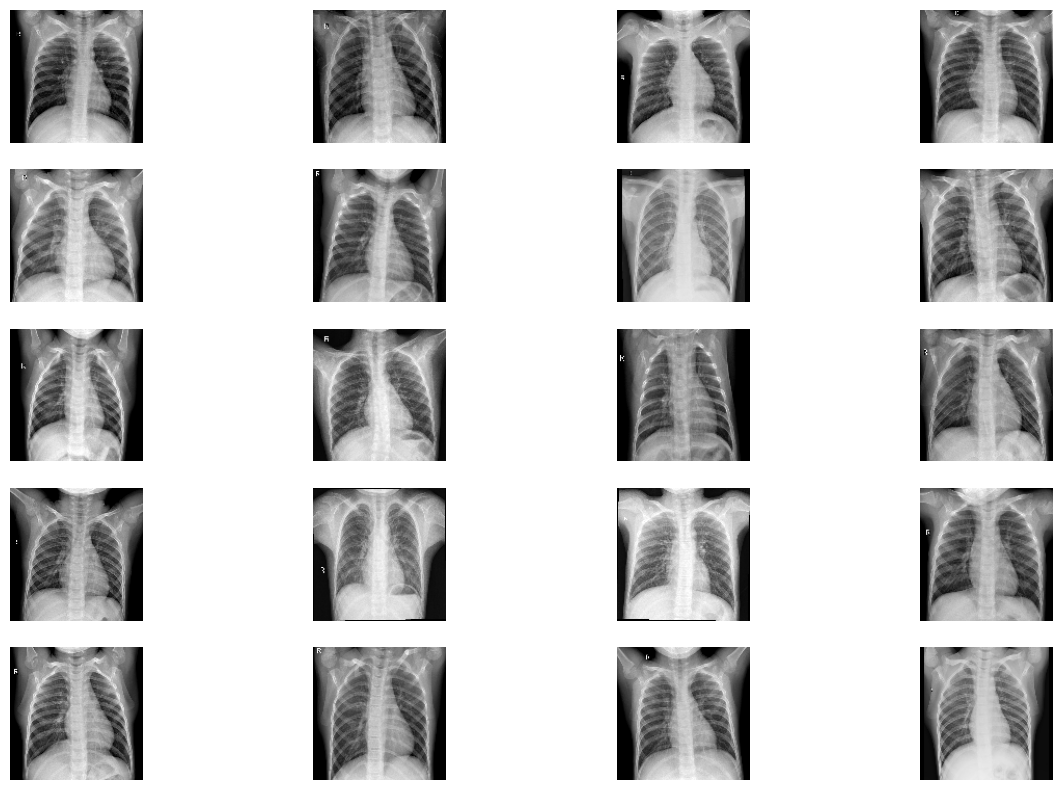

In [ ]:
# Shuffle the images randomly
random.shuffle(all_normal)
random.shuffle(all_pneumonia)

# Select a subset of images for visualization
images = all_normal[:50] + all_pneumonia[:50]

# Viewing the images in X-ray
fig = plt.figure(figsize=(15, 10))
columns = 4
rows = 5

for i in range(1, columns * rows + 1):
    img_path = images[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))

    fig.add_subplot(rows, columns, i)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis(False)

plt.show()

**Now let’s try Ben Graham’s method. First, we convert the images to greyscale and then apply Gaussian blur to them.**

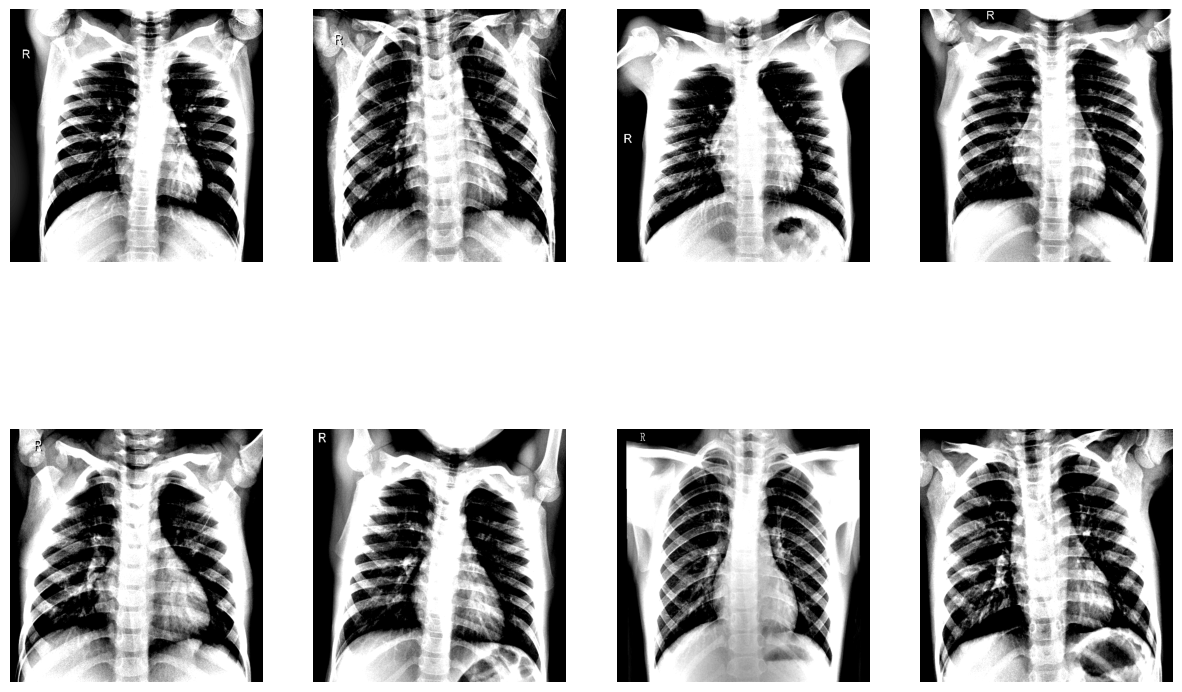

In [ ]:
fig = plt.figure(figsize=(15, 10))
columns = 4
rows = 2

for i in range(1, columns * rows + 1):
    img_path = images[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 512 / 10), -4, 128)

    fig.add_subplot(rows, columns, i)

    plt.imshow(img, cmap='gray')  # Display the grayscale image
    plt.axis(False)

plt.show()

**Now, let’s look into the pixel distributions. We’ll use the Fourier method for this.**

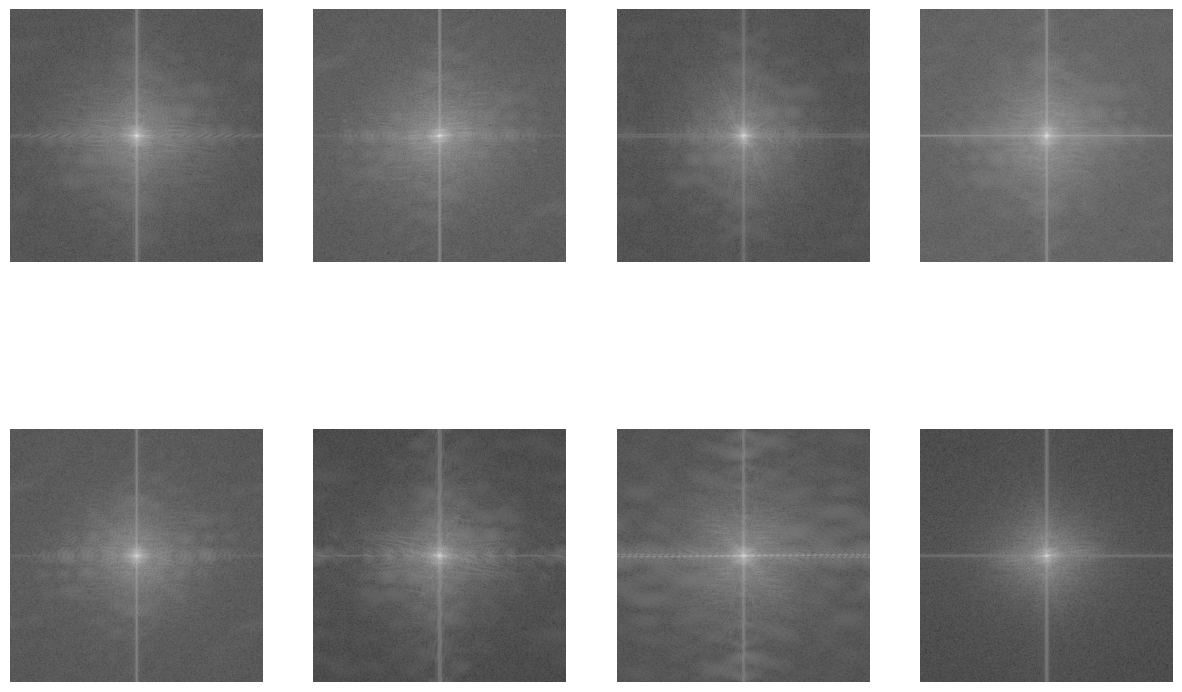

In [ ]:
# Analyzing pixel distributions using Fourier method
fig = plt.figure(figsize=(15, 10))
columns = 4
rows = 2

for i in range(1, columns * rows + 1):
    img_path = images[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    fig.add_subplot(rows, columns, i)

    plt.imshow(magnitude_spectrum, cmap='gray')  # Display the magnitude spectrum
    plt.axis(False)

plt.show()

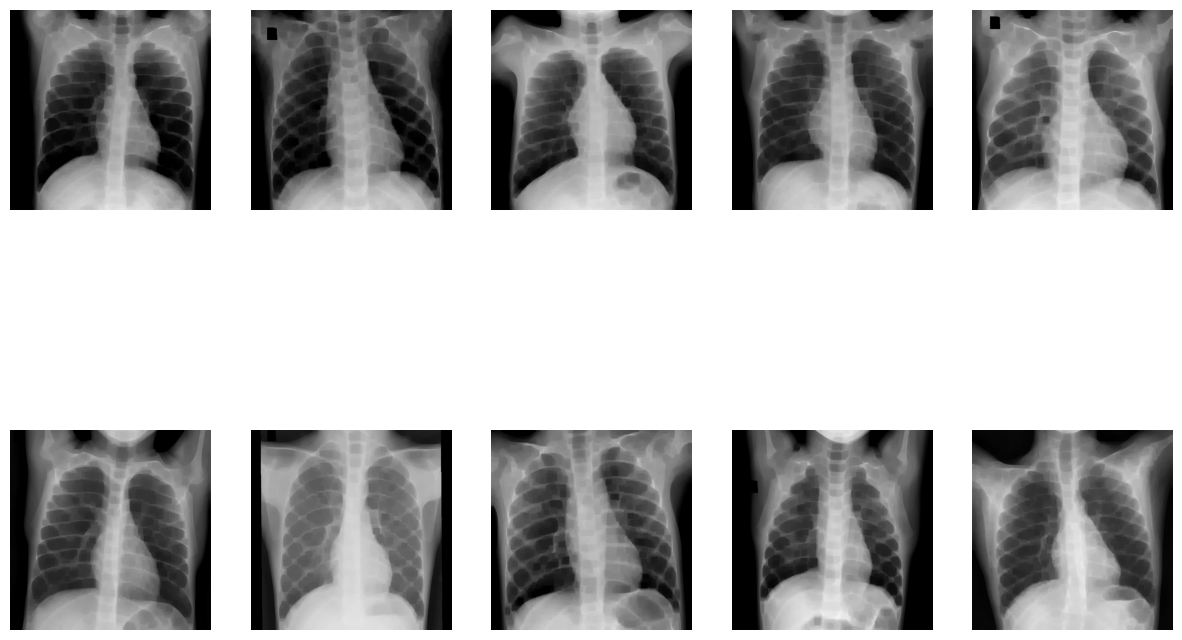

In [ ]:
# Applying image erosion
fig = plt.figure(figsize=(15, 10))
columns = 5
rows = 2

for i in range(1, columns * rows + 1):
    img_path = images[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)

    fig.add_subplot(rows, columns, i)

    plt.imshow(img_erosion)
    plt.axis(False)

plt.show()

#**dilation**

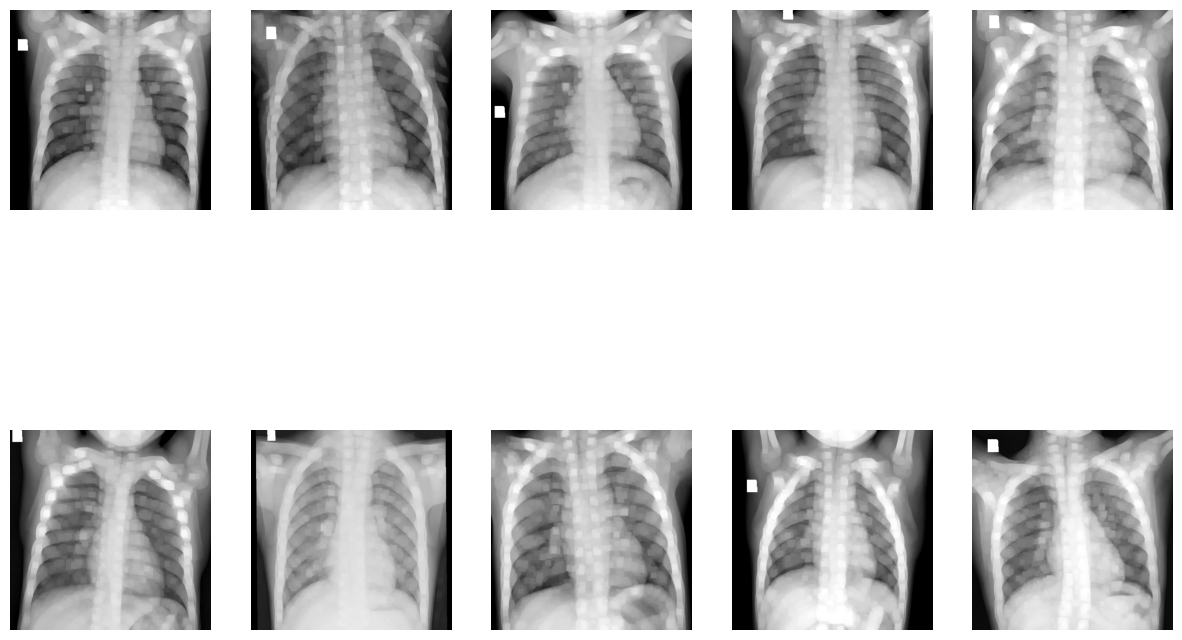

In [ ]:
# Applying image dilation
fig = plt.figure(figsize=(15, 10))
columns = 5
rows = 2

for i in range(1, columns * rows + 1):
    img_path = images[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    kernel = np.ones((5, 5), np.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=3)

    fig.add_subplot(rows, columns, i)

    plt.imshow(img_dilation)
    plt.axis(False)

plt.show()

In [ ]:
# Define custom preprocessing function
def preprocess_image(img):
    # Convert to single-channel (grayscale)
    original_image = img[:, :, 0].astype(np.uint8)  # Ensure that it's of type uint8

    # Find maximum and minimum intensity
    min_intensity = np.min(original_image)
    max_intensity = np.max(original_image)

    # Apply binary thresholding
    _, thresholded_image = cv2.threshold(original_image, (max_intensity + min_intensity) / 2, 255, cv2.THRESH_BINARY)

    # Apply morphologic closing
    kernel = np.ones((5, 5), np.uint8)
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

    # Create adaptive mask
    adaptive_mask = cv2.bitwise_not(closed_image)

    # Apply bitwise operation to remove diaphragm
    masked_image = cv2.bitwise_and(original_image, original_image, mask=adaptive_mask)

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(masked_image)

    # Apply Gaussian blur
    final_preprocessed_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

    # Replicate single channel to create a grayscale image
    final_preprocessed_image_rgb = np.stack([final_preprocessed_image] * 3, axis=-1)

    return final_preprocessed_image_rgb.astype(np.float32) / 255.0





#**OpenCV’s Canny Edge Detection:**

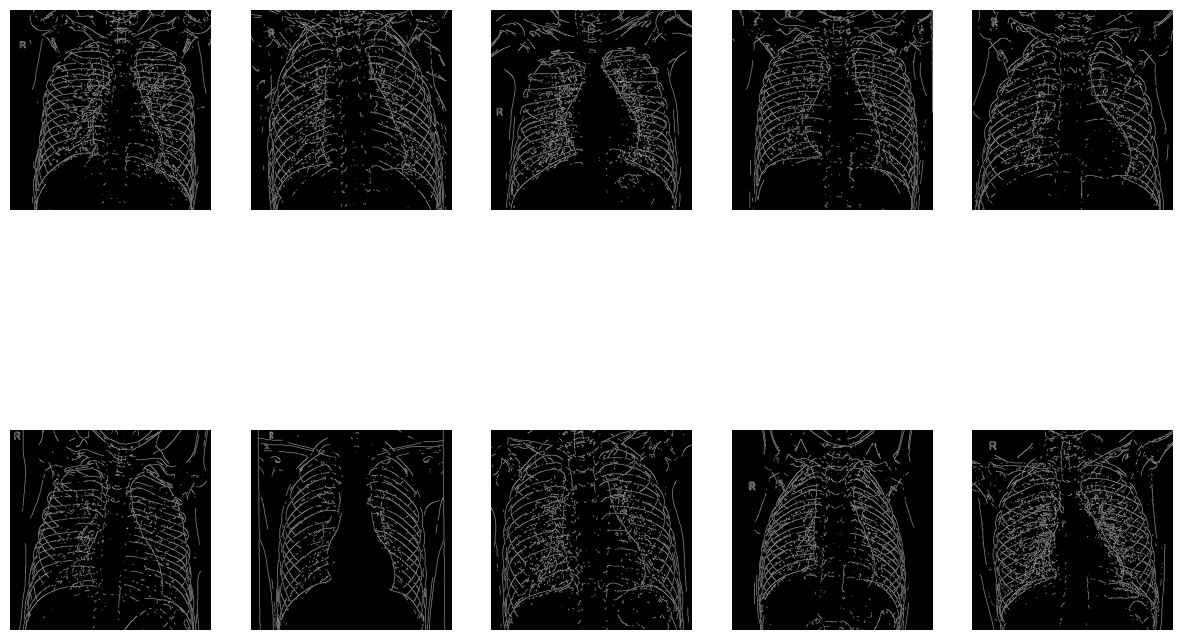

In [ ]:
# Applying Canny Edge Detection
fig = plt.figure(figsize=(15, 10))
columns = 5
rows = 2

for i in range(1, columns * rows + 1):
    img_path = images[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img_gray, 80, 100)

    fig.add_subplot(rows, columns, i)

    plt.imshow(edges, cmap='gray')  # Display the edges in grayscale
    plt.axis(False)

plt.show()

#**5) Model Building**

In [ ]:
# Define ImageDataGenerators for training and validation
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.2,
    zoom_range=0.2
)

val_gen = ImageDataGenerator(
    rescale=1/255.,
)

# Flowing the data in the Data Generator
Train = train_gen.flow_from_directory(
    os.path.join(base_path, 'train'),  # Adjust the path based on your folder structure
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Assuming a binary classification task, adjust as needed
)

Test = val_gen.flow_from_directory(
    os.path.join(base_path, 'test'),  # Adjust the path based on your folder structure
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Assuming a binary classification task, adjust as needed
)

Found 1644 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#**VGG16**

In [ ]:
# Image dimensions
img_width, img_height = 224, 224

In [ ]:
#Import VGG16 with pre-trained weights
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze existing weights
for layer in vgg.layers:
    layer.trainable = False

# Add custom fully connected layers for binary classification
model_vgg = Sequential([
    vgg,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Define callbacks
checkpoint_path = '/content/drive/MyDrive/model_checkpoint/vgg16.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, mode='auto', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


# Compile the model
start_time = time.time()
model_vgg.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
end_time = time.time()

# Train the model
r = model_vgg.fit(
    Train,
    validation_data=Test,
    epochs=10,
    callbacks=[checkpoint, early_stopping])

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8856 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 1335s 26s/step - loss: 0.3295 - accuracy: 0.8856 - val_loss: 0.2732 - val_accuracy: 0.8942
Epoch 2/10
52/52 [==============================] - 1286s 25s/step - loss: 0.1233 - accuracy: 0.9532 - val_loss: 0.2049 - val_accuracy: 0.9231
Epoch 3/10
52/52 [==============================] - 1303s 25s/step - loss: 0.0927 - accuracy: 0.9647 - val_loss: 0.4507 - val_accuracy: 0.8526
Epoch 4/10
52/52 [==============================] - 1330s 26s/step - loss: 0.1004 - accuracy: 0.9665 - val_loss: 0.4562 - val_accuracy: 0.8686
Epoch 5/10
52/52 [==============================] - 1276s 25s/step - loss: 0.1105 - accuracy: 0.9605 - val_loss: 0.3279 - val_accuracy: 0.9054


In [ ]:
# Load the best model
model_vgg = load_model('/content/drive/MyDrive/model_checkpoint/vgg16.h5')

# Evaluate the model on the test set
loss, accuracy= model_vgg.evaluate(Test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

20/20 [==============================] - 388s 19s/step - loss: 0.2049 - accuracy: 0.9231
Test accuracy: 92.31%


In [ ]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17926209 (68.38 MB)
Trainable params: 3211521 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model_vgg = load_model('/content/drive/MyDrive/model_checkpoint/vgg16.h5')

In [ ]:
# Predict on the test set
y_pred = model_vgg.predict(Test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

20/20 [==============================] - 220s 11s/step


In [ ]:
# Calculate additional metrics
accuracy = accuracy_score(Test.classes, y_pred_binary)
precision = precision_score(Test.classes, y_pred_binary)
recall = recall_score(Test.classes, y_pred_binary)


print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Accuracy: 58.65%
Precision: 66.42%
Recall: 68.46%


#**RESNET_50**

In [ ]:
# Define image dimensions
img_width_r, img_height_r = 224, 224
# Load pre-trained ResNet-50 model without top layers
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width_r, img_height_r, 3))
# Freeze the layers of the pre-trained model
for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
# Add custom fully connected layers for binary classification
model_resnet = Sequential([
    resnet,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [ ]:
# Define callbacks
checkpoint_path = '/content/drive/MyDrive/model_checkpointresnet/resnet.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, mode='auto', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
#Compile the model
model_resnet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
q = model_resnet.fit(Train, validation_data=Test, epochs=10,callbacks=[checkpoint, early_stopping])




Epoch 1/10
52/52 [==============================] - 477s 9s/step - loss: 2.1610 - accuracy: 0.6509 - val_loss: 0.5392 - val_accuracy: 0.7788
Epoch 2/10
52/52 [==============================] - 458s 9s/step - loss: 0.4386 - accuracy: 0.7883 - val_loss: 0.5070 - val_accuracy: 0.7901
Epoch 3/10
52/52 [==============================] - 474s 9s/step - loss: 0.3904 - accuracy: 0.8187 - val_loss: 0.4265 - val_accuracy: 0.8221
Epoch 4/10
52/52 [==============================] - 517s 10s/step - loss: 0.3587 - accuracy: 0.8327 - val_loss: 0.3958 - val_accuracy: 0.8317
Epoch 5/10
52/52 [==============================] - 492s 9s/step - loss: 0.3521 - accuracy: 0.8412 - val_loss: 0.5864 - val_accuracy: 0.7099
Epoch 6/10
52/52 [==============================] - 473s 9s/step - loss: 0.3288 - accuracy: 0.8564 - val_loss: 0.4090 - val_accuracy: 0.7981
Epoch 7/10
52/52 [==============================] - 478s 9s/step - loss: 0.2983 - accuracy: 0.8644 - val_loss: 0.3522 - val_accuracy: 0.8381
Epoch 8/10
5

In [ ]:
# Load the best model
model_resnet = load_model('/content/drive/MyDrive/model_checkpointresnet/resnet.h5')

# Evaluate the model on the test set
loss, accuracy = model_resnet.evaluate(Test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

20/20 [==============================] - 112s 5s/step - loss: 0.3522 - accuracy: 0.8381
Test accuracy: 83.81%


In [ ]:
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36433025 (138.98 MB)
Trainable params: 12845313 (49.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# Load the best model
model_resnet = load_model('/content/drive/MyDrive/model_checkpointresnet/resnet.h5')


In [ ]:
# Predict on test set
y_pred = model_resnet.predict(Test)

20/20 [==============================] - 79s 4s/step


In [ ]:
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

In [ ]:
# Calculate additional metrics
accuracy = accuracy_score(Test.classes, y_pred_binary)
precision = precision_score(Test.classes, y_pred_binary)
recall = recall_score(Test.classes, y_pred_binary)

In [ ]:
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Accuracy: 55.61%
Precision: 62.75%
Recall: 71.28%


#**MobileNetV2**

In [ ]:
# Define image dimensions
img_width_m, img_height_m = 224, 224

# Load pre-trained MobileNetV2 model without top layers
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width_m, img_height_m, 3))

# Freeze the layers of the pre-trained model
for layer in mobilenet.layers:
    layer.trainable = False

# Adding Flatten layer instead of GlobalAveragePooling2D
model_mobilenet = Sequential([
    mobilenet,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Define callbacks
checkpoint_path = '/content/drive/MyDrive/model_checkpointmobilenet/mobilenet.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, mode='auto', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
#Compile the model
model_mobilenet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
e = model_mobilenet.fit(Train, validation_data=Test, epochs=10,callbacks=[checkpoint, early_stopping])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 1.1210 - accuracy: 0.9057

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 387s 7s/step - loss: 1.1210 - accuracy: 0.9057 - val_loss: 1.1809 - val_accuracy: 0.8926
Epoch 2/10
52/52 [==============================] - 143s 3s/step - loss: 0.2576 - accuracy: 0.9568 - val_loss: 1.1342 - val_accuracy: 0.8750
Epoch 3/10
52/52 [==============================] - 125s 2s/step - loss: 0.1967 - accuracy: 0.9586 - val_loss: 1.1398 - val_accuracy: 0.8654
Epoch 4/10
52/52 [==============================] - 126s 2s/step - loss: 0.4392 - accuracy: 0.9459 - val_loss: 0.5936 - val_accuracy: 0.9199
Epoch 5/10
52/52 [==============================] - 125s 2s/step - loss: 0.2119 - accuracy: 0.9696 - val_loss: 0.6722 - val_accuracy: 0.9103
Epoch 6/10
52/52 [==============================] - 137s 3s/step - loss: 0.1282 - accuracy: 0.9745 - val_loss: 0.8747 - val_accuracy: 0.8974
Epoch 7/10
52/52 [==============================] - 138s 3s/step - loss: 0.0801 - accuracy: 0.9830 - val_loss: 0.9252 - val_accuracy: 0.8846


In [ ]:
# Load the best model
model_mobilenet = load_model('/content/drive/MyDrive/model_checkpointmobilenet/mobilenet.h5')

# Evaluate the model on the test set
loss, accuracy = model_mobilenet.evaluate(Test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

20/20 [==============================] - 26s 1s/step - loss: 0.5936 - accuracy: 0.9199
Test accuracy: 91.99%


In [ ]:
model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10286401 (39.24 MB)
Trainable params: 8028417 (30.63 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Load the best model
model_mobilenet = load_model('/content/drive/MyDrive/model_checkpointmobilenet/mobilenet.h5')

In [ ]:
# Predict on test set
y_pred = model_mobilenet.predict(Test)

20/20 [==============================] - 26s 1s/step


In [ ]:
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

In [ ]:
# Calculate additional metrics
accuracy = accuracy_score(Test.classes, y_pred_binary)
precision = precision_score(Test.classes, y_pred_binary)
recall = recall_score(Test.classes, y_pred_binary)

In [ ]:
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Accuracy: 54.49%
Precision: 63.52%
Recall: 63.85%


#**DenseNet121**

In [ ]:
# Define image dimensions
img_width_d, img_height_d = 224, 224

# Load pre-trained DenseNet121 model without top layers
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width_d, img_height_d, 3))

# Freeze the layers of the pre-trained model
for layer in densenet.layers:
    layer.trainable = False

# Adding Flatten layer instead of GlobalAveragePooling2D
model_densenet = Sequential([
    densenet,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Define callbacks
checkpoint_path_d = '/content/drive/MyDrive/model_checkpointdensenet/densenet.h5'
checkpoint_d = ModelCheckpoint(filepath=checkpoint_path_d, mode='auto', save_best_only=True)
early_stopping_d = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Compile the model
model_densenet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
e_d = model_densenet.fit(Train, validation_data=Test, epochs=10, callbacks=[checkpoint_d, early_stopping_d])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 2.0790 - accuracy: 0.8467

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 468s 9s/step - loss: 2.0790 - accuracy: 0.8467 - val_loss: 4.0123 - val_accuracy: 0.7804
Epoch 2/10
52/52 [==============================] - 383s 7s/step - loss: 0.3940 - accuracy: 0.9440 - val_loss: 1.3112 - val_accuracy: 0.8798
Epoch 3/10
52/52 [==============================] - 386s 7s/step - loss: 0.1900 - accuracy: 0.9568 - val_loss: 1.2167 - val_accuracy: 0.8670
Epoch 4/10
52/52 [==============================] - 449s 9s/step - loss: 0.1450 - accuracy: 0.9665 - val_loss: 0.7131 - val_accuracy: 0.9038
Epoch 5/10
52/52 [==============================] - 424s 8s/step - loss: 0.2687 - accuracy: 0.9544 - val_loss: 0.5274 - val_accuracy: 0.9263
Epoch 6/10
52/52 [==============================] - 435s 8s/step - loss: 0.1747 - accuracy: 0.9653 - val_loss: 0.9352 - val_accuracy: 0.8878
Epoch 7/10
52/52 [==============================] - 435s 8s/step - loss: 0.1215 - accuracy: 0.9690 - val_loss: 1.4517 - val_accuracy: 0.8205
Epoch 8/10
52/52 [======

In [ ]:
# Load the best model
model_densenet = load_model('/content/drive/MyDrive/model_checkpointdensenet/densenet.h5')

In [ ]:
# Evaluate the model on the test set
loss_d, accuracy_d = model_densenet.evaluate(Test)
print(f"Test accuracy: {accuracy_d * 100:.2f}%")

20/20 [==============================] - 113s 5s/step - loss: 0.5274 - accuracy: 0.9263
Test accuracy: 92.63%


In [ ]:
model_densenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13460289 (51.35 MB)
Trainable params: 6422785 (24.50 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:
# Load the best model
model_densenet = load_model('/content/drive/MyDrive/model_checkpointdensenet/densenet.h5')

In [ ]:
# Predict on test set
y_pred_d = model_densenet.predict(Test)

# Convert probabilities to binary predictions
y_pred_binary_d = (y_pred_d > 0.5).astype(int)


20/20 [==============================] - 75s 4s/step


In [ ]:
# Calculate additional metrics
accuracy_d = accuracy_score(Test.classes, y_pred_binary_d)
precision_d = precision_score(Test.classes, y_pred_binary_d)
recall_d = recall_score(Test.classes, y_pred_binary_d)

In [ ]:
print(f"Accuracy: {accuracy_d * 100:.2f}%")
print(f"Precision: {precision_d * 100:.2f}%")
print(f"Recall: {recall_d * 100:.2f}%")

Accuracy: 52.56%
Precision: 61.63%
Recall: 63.85%


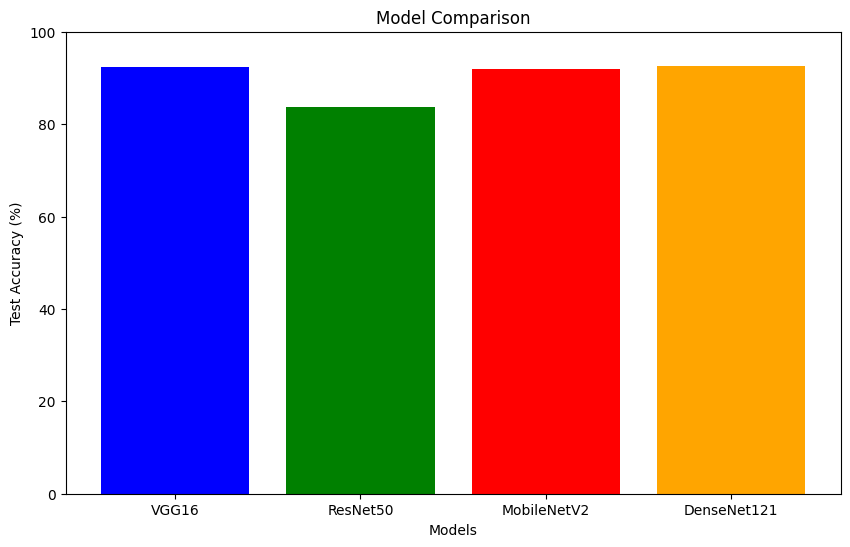

In [ ]:
import matplotlib.pyplot as plt

models = ['VGG16', 'ResNet50', 'MobileNetV2','DenseNet121']
test_accuracies = [92.31,83.81, 91.99,92.63]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, test_accuracies, color=['blue', 'green', 'red','orange'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(0, 100)
plt.show()


MobileNetV2: MobileNetV2 is designed to be lightweight and efficient, making it faster than the other models on the list. It's particularly well-suited for mobile and edge devices.

VGG16: VGG16 has a relatively simple and uniform architecture compared to more recent models, but it has a larger number of parameters than MobileNetV2. It's generally faster than deeper architectures like ResNet50 or DenseNet121.

DenseNet121: DenseNet models, including DenseNet121, have a unique architecture that encourages feature reuse. They are more parameter-efficient than VGG-style networks but may be slower to compute due to their denser connectivity.

ResNet50: ResNet50 is a deeper architecture that introduced the concept of residual connections, allowing for the training of very deep networks. It has more parameters than VGG16 and may require more computation time.

VGG16:

Test Accuracy: 92.31%

Precision: 66.42%

Recall: 68.46%

ResNet50:

Test Accuracy: 83.81%

Precision: 62.75%

Recall: 71.28%

MobileNetV2:

Test Accuracy: 91.99%

Precision: 63.52%

Recall: 63.85%

DenseNet121:

Test Accuracy: 92.63%

Precision: 61.63%

Recall: 63.85%

Analysis:
Test Accuracy: All models show reasonably high accuracy, with VGG16 and DenseNet121 slightly outperforming the others.
Precision and Recall: Precision and recall are crucial for imbalanced datasets, such as pneumonia detection. VGG16 and ResNet50 show a good balance between precision and recall.

Considering the balance between accuracy, precision, and recall, VGG16 and ResNet50 seem promising.